<a href="https://colab.research.google.com/github/fambargh/man/blob/master/increese_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-sqhdawpl
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-sqhdawpl
     |████████████████████████████████| 634kB 8.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61973 sha256=e7702a5f082d5d743e35d1776882eee6e06ccbbcc98e2220b36cec1c3bcb1006
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9cvhsmv/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4c9203847173dcd9b66c30310f91bf46931ebf6b2132996789d724c90fb8d511
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9cvhsmv/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [2]:
# Install required libs 
!pip install -U --pre segmentation-models --user

In [3]:
from zipfile import ZipFile
filename = "mm.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
from zipfile import ZipFile
filename = "annotation_cup.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
from zipfile import ZipFile
filename = "annotation_disc.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

In [7]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train_dir = '/content/train/'
y_train_dir = '/content/test/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/annotation_cup_valid'

x_test_dir = '/content/image_test/'
y_test_dir = '/content/annotation_cup_test/'

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'oc','s']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. oc)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


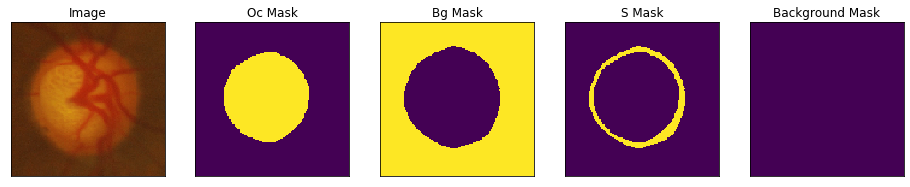

1

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['oc','bg','s'])
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    s_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
    )
len(dataset)

In [0]:
import albumentations as A


In [7]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [0]:
preprocess_input = sm.get_preprocessing('densenet121')

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 255)

 #define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(128,128),
        #A.HueSaturationValue(p=1),
        A.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.1, p=1, border_mode=1),


    ]
    return A.Compose(test_transform)
    


/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


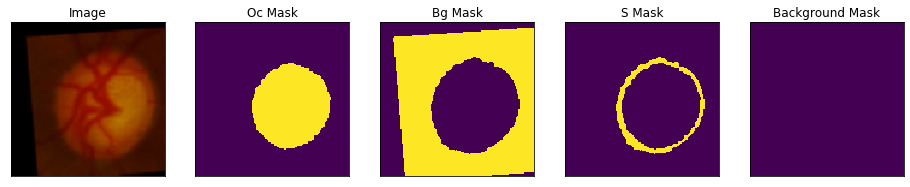

128

In [16]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['oc','bg','s'], augmentation=get_training_augmentation())
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    s_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
    )
len(image)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


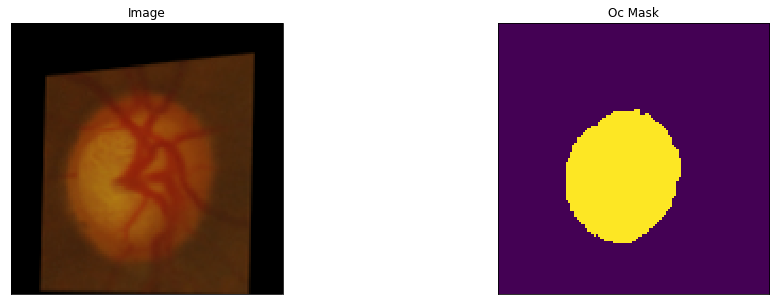

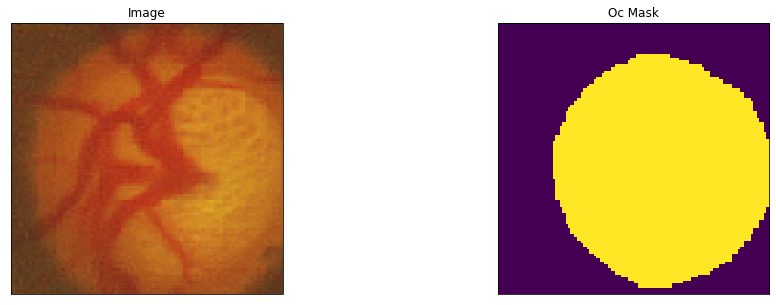

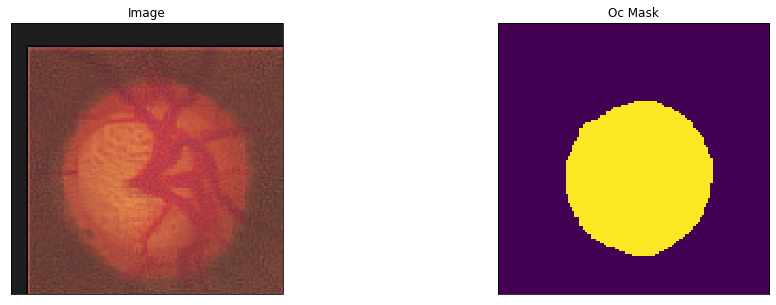

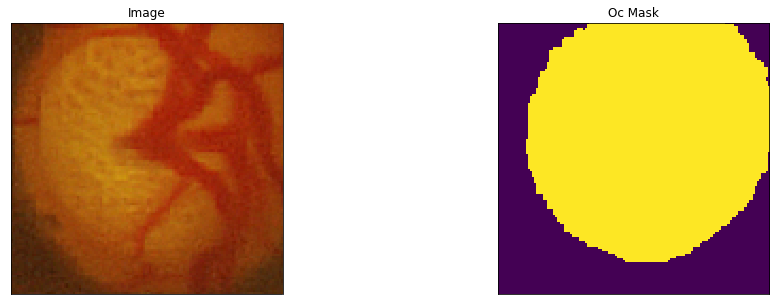

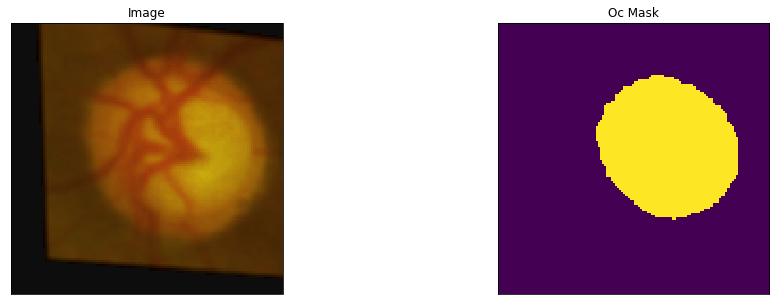

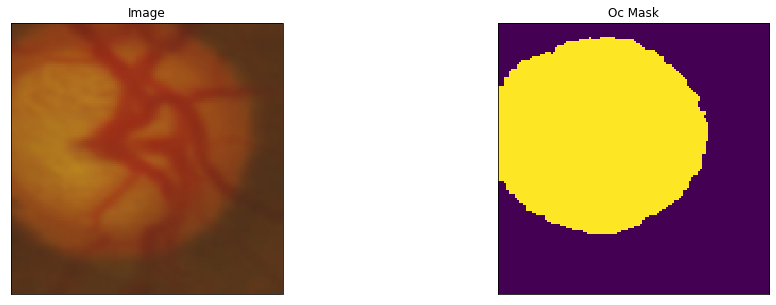

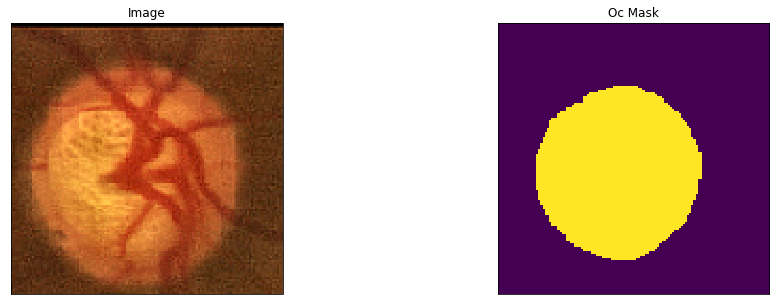

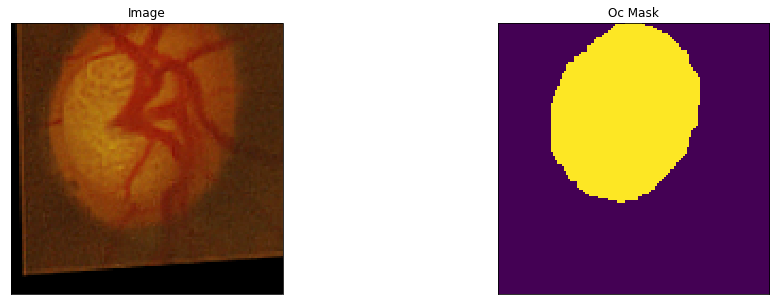

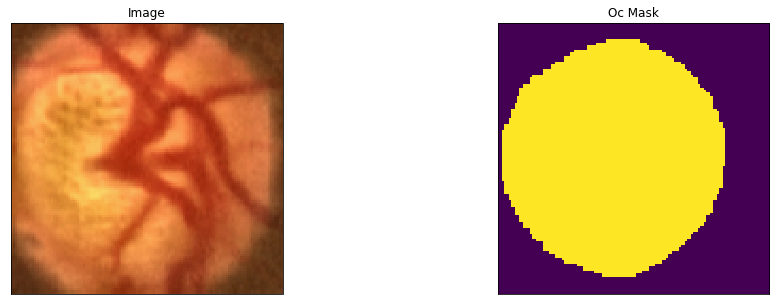

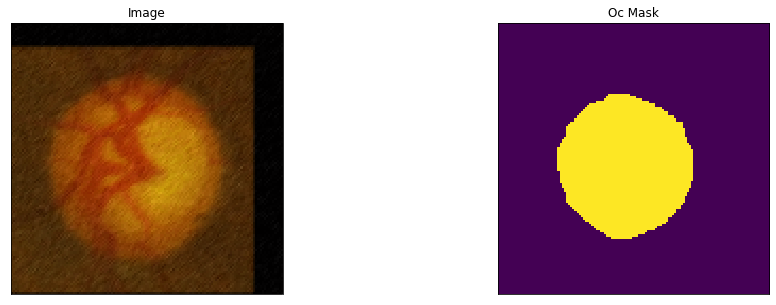

In [26]:
import numpy
import cv2
dataset = Dataset(x_train_dir, y_train_dir, classes=['oc'], augmentation=get_training_augmentation())
for i in range(0,10):
  image, mask = dataset[0] # get some sample
  out_arr = numpy.squeeze(mask)  
  cv2.imwrite('/content/resault_disc/{}.png'.format(i),out_arr)
  cv2.imwrite('/content/resault_disc1/{}.png'.format(i),image)
  visualize(
      image=image, 
      OC_mask=mask[..., 0].squeeze(),
      #bg_mask=mask[..., 1].squeeze(),
      #nolabeled_mask=mask[..., 2].squeeze(),
      #background_mask=mask[..., 3].squeeze(),
      )
#print(image.shape)

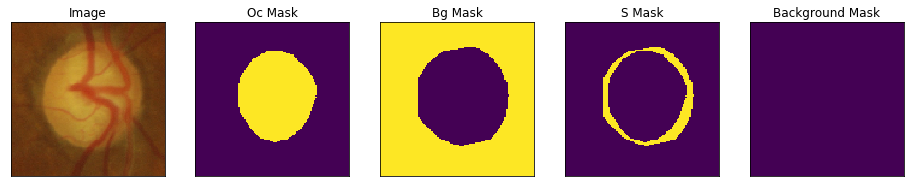

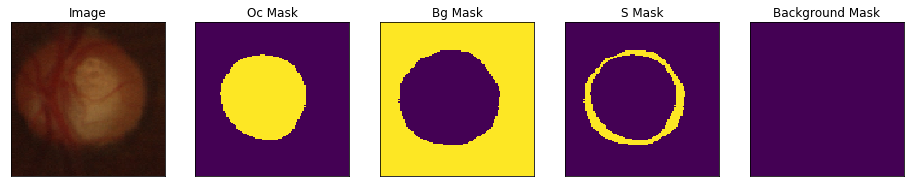

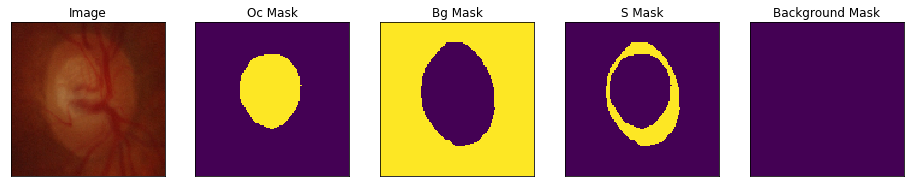

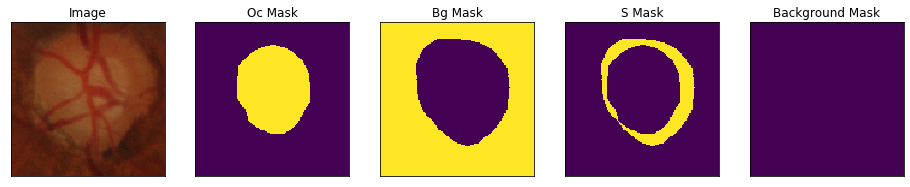

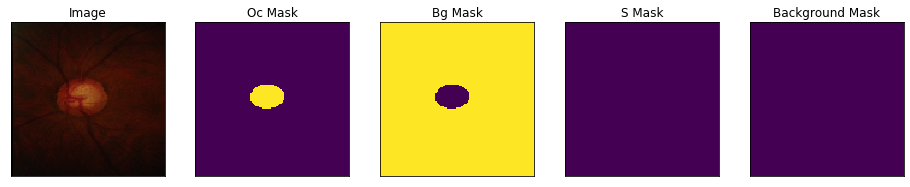

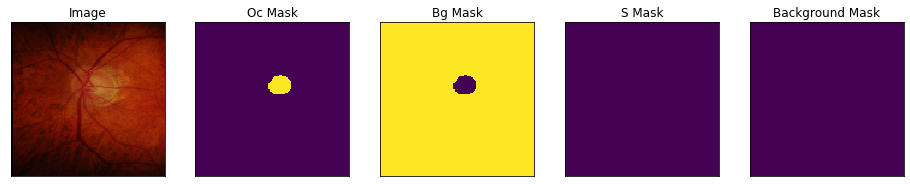

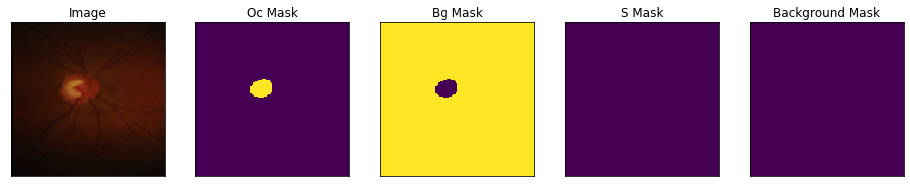

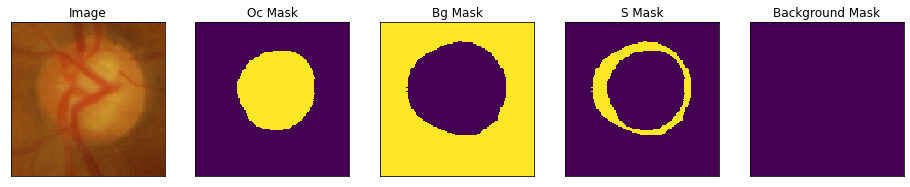

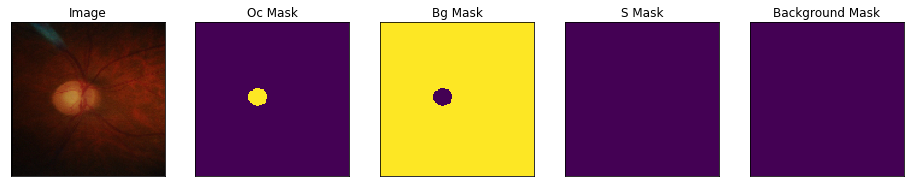

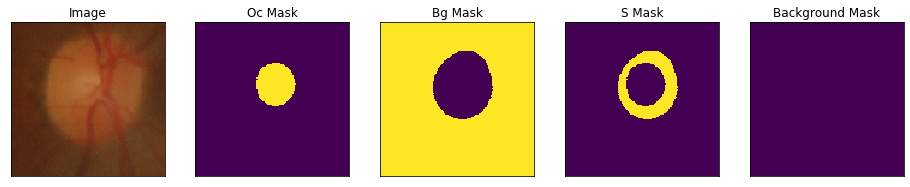

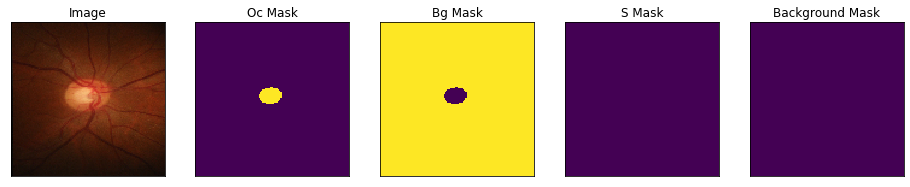

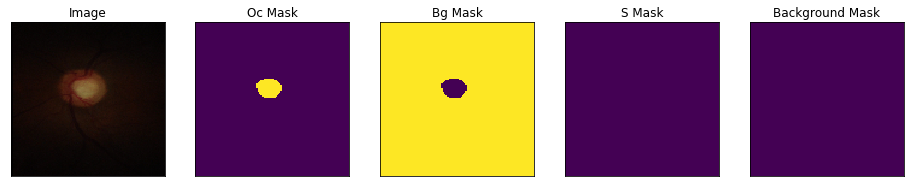

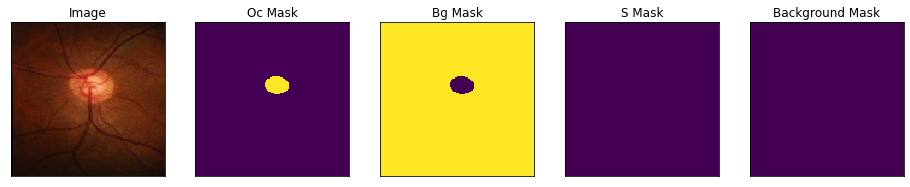

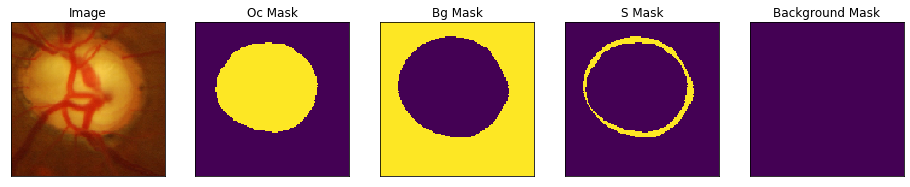

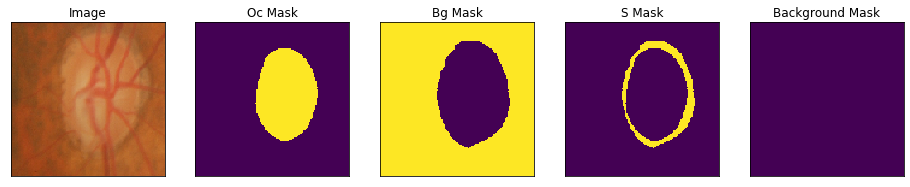

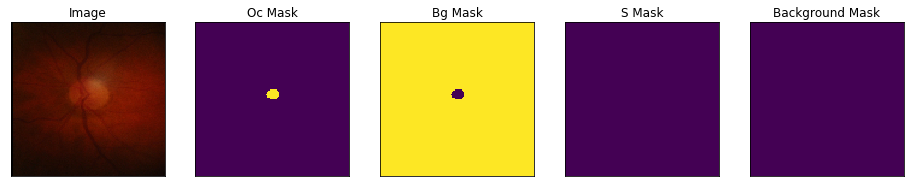

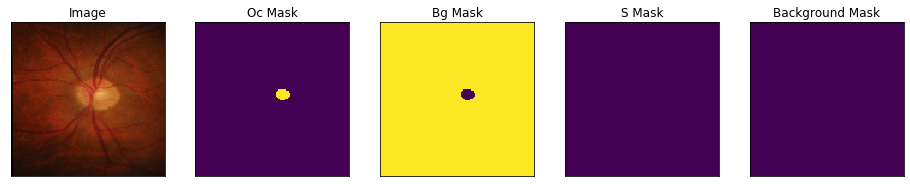

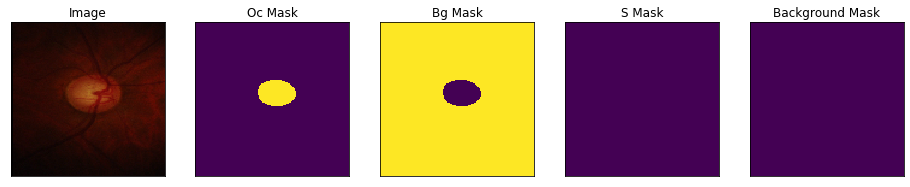

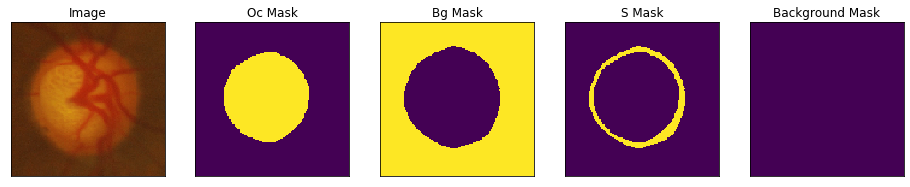

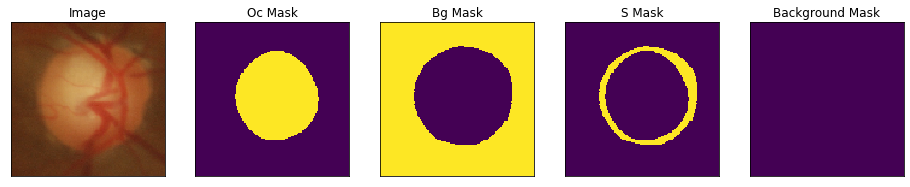

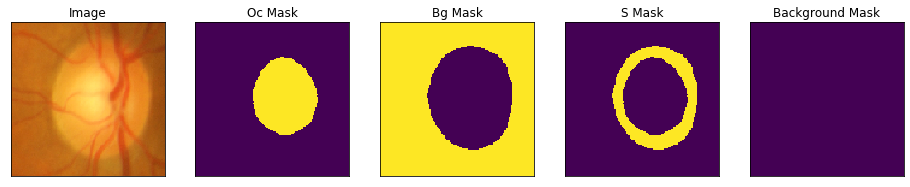

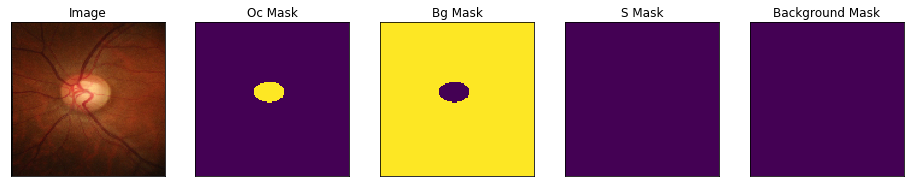

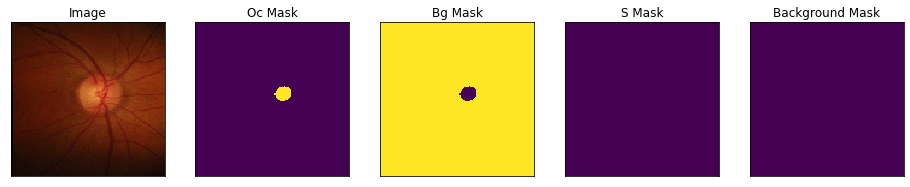

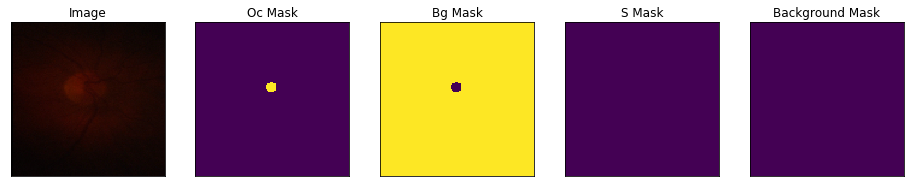

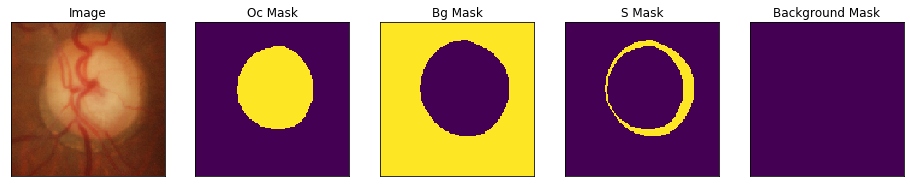

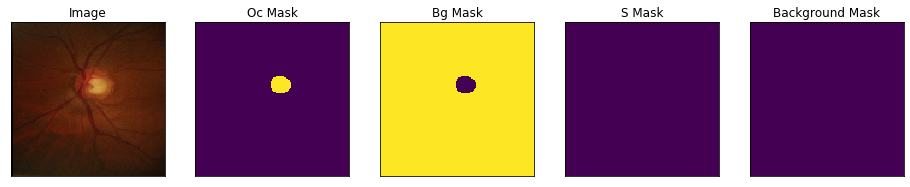

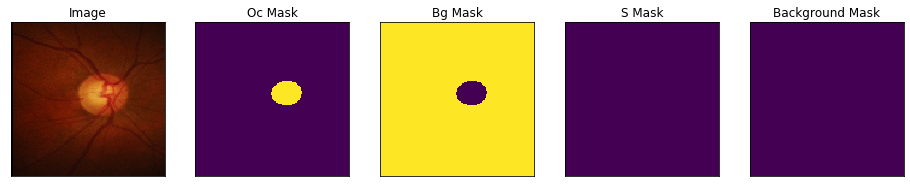

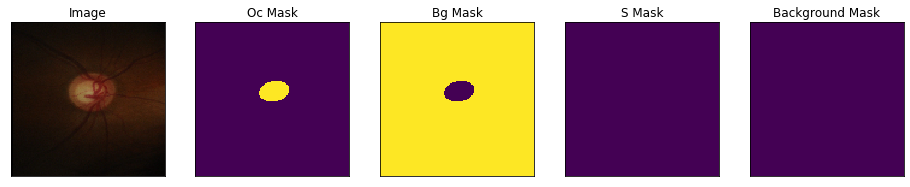

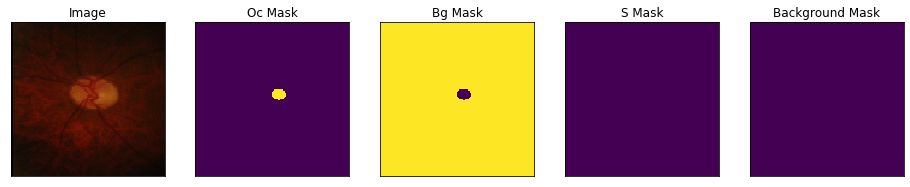

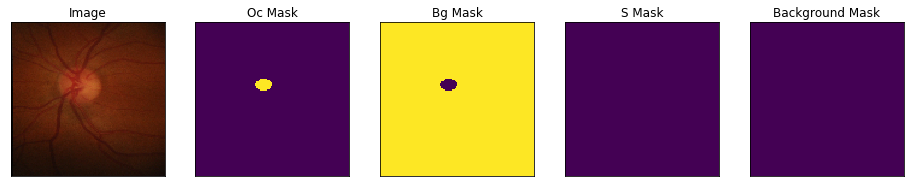

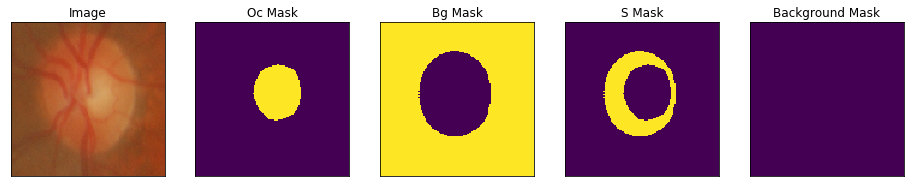

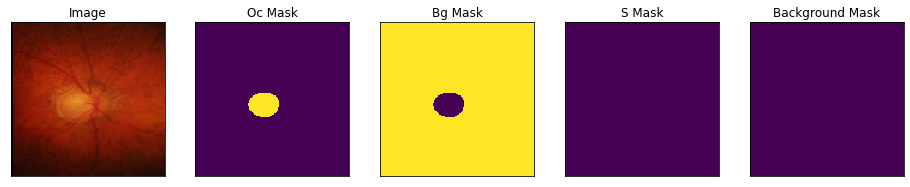

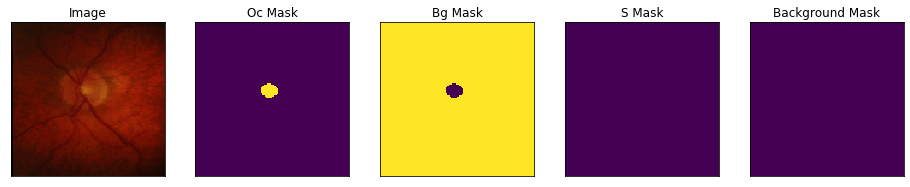

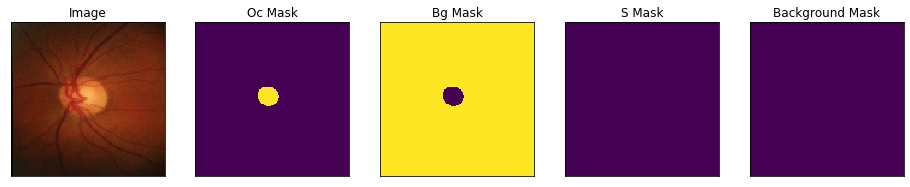

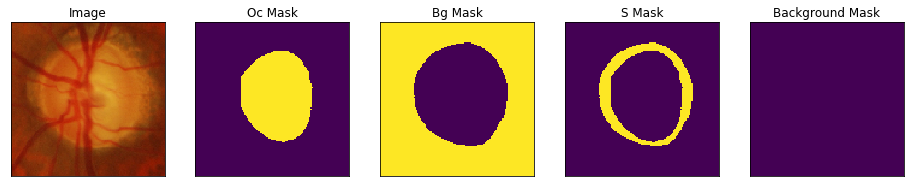

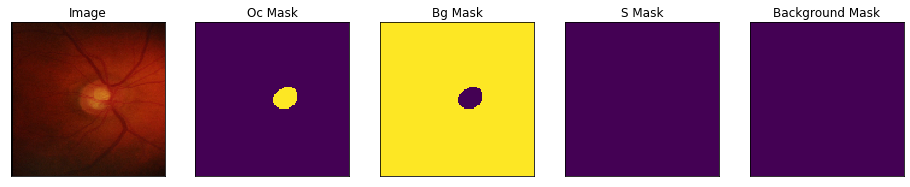

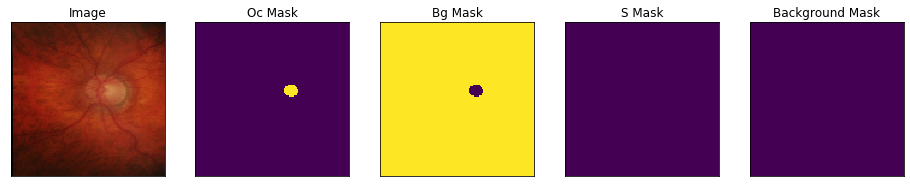

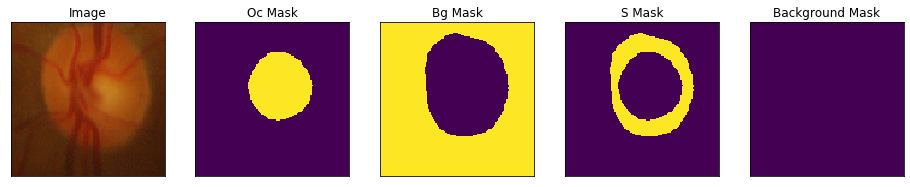

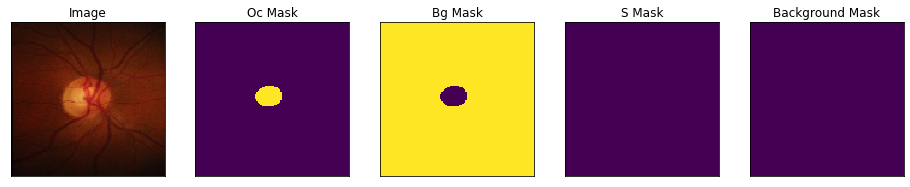

In [0]:
dataset = Dataset(x_test_dir, y_test_dir, classes=['oc','bg','s'])
for i in range(39):
  image, mask = dataset[i] # get some sample
  visualize(
      image=image, 
      OC_mask=mask[..., 0].squeeze(),
      bg_mask=mask[..., 1].squeeze(),
      s_mask=mask[..., 2].squeeze(),
      background_mask=mask[..., 3].squeeze(),
      )

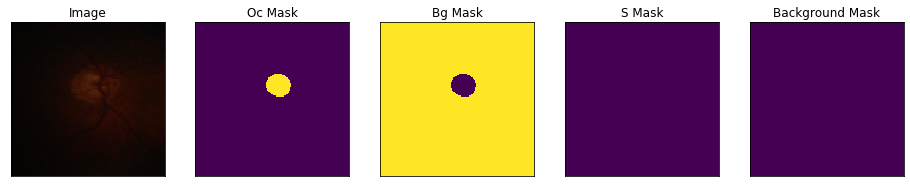

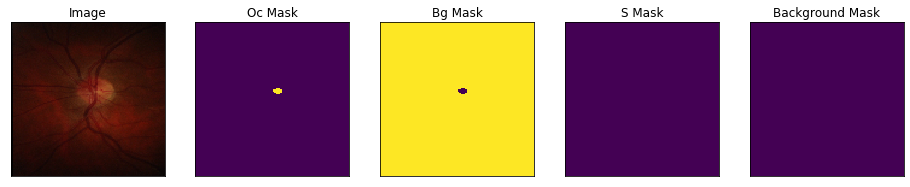

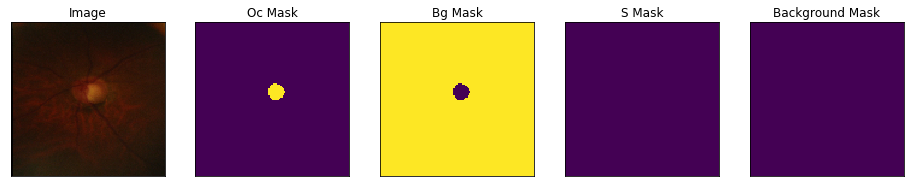

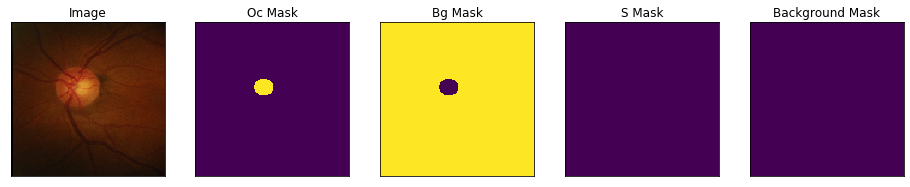

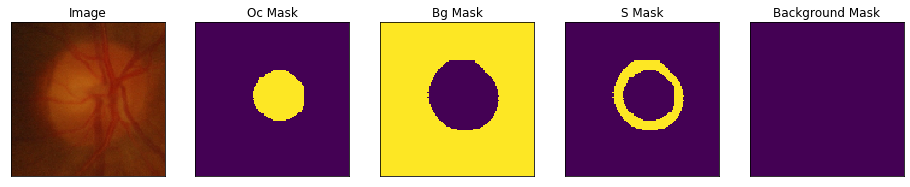

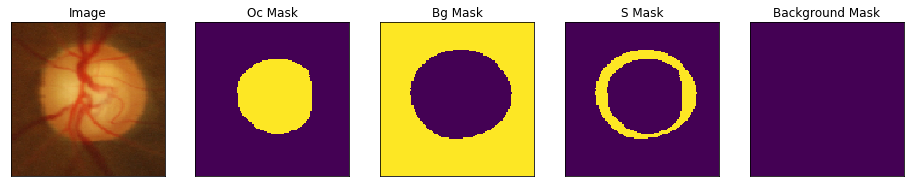

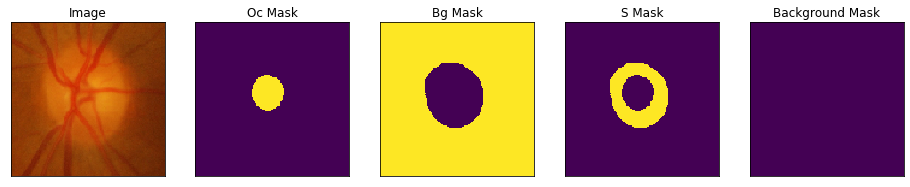

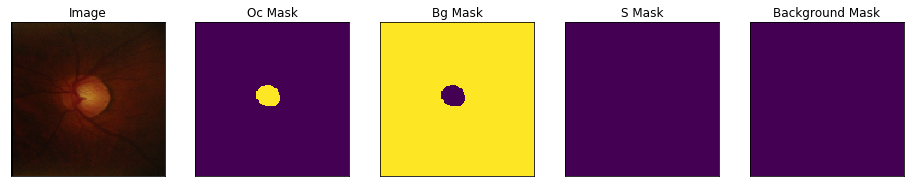

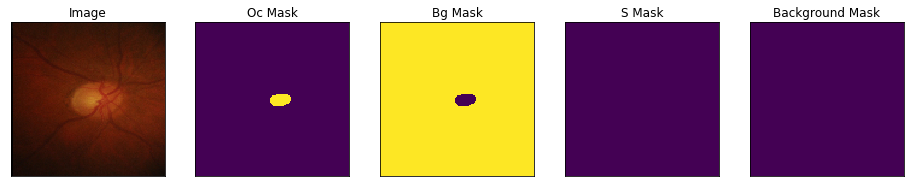

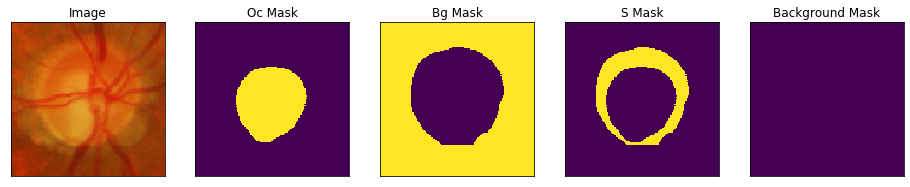

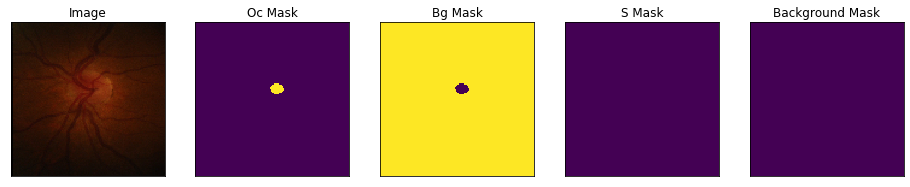

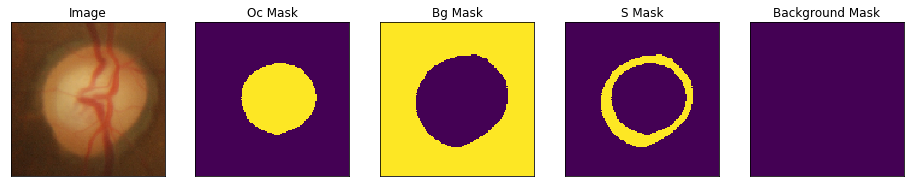

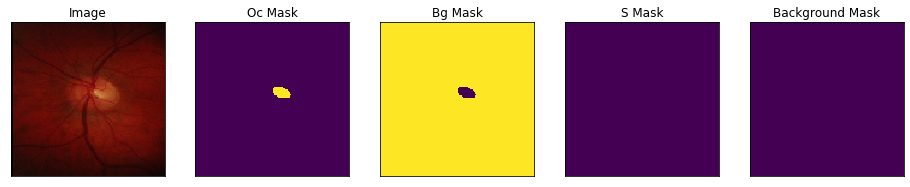

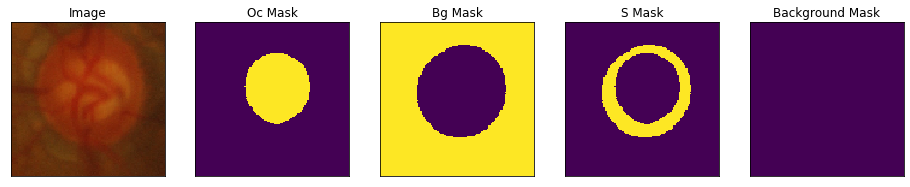

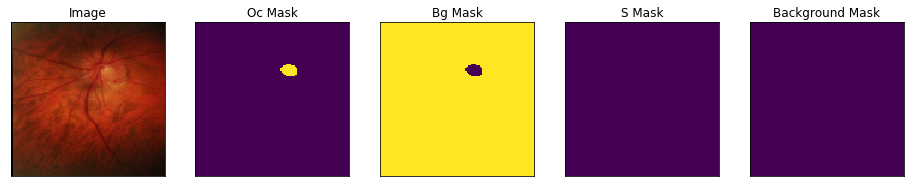

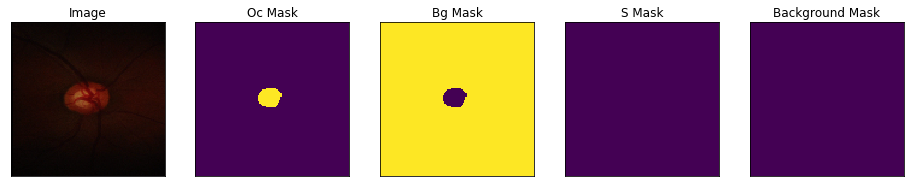

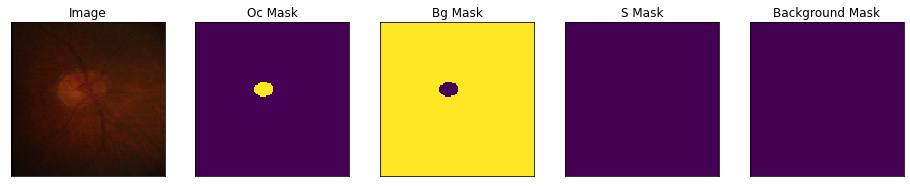

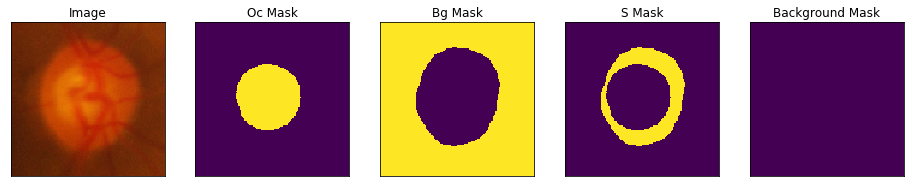

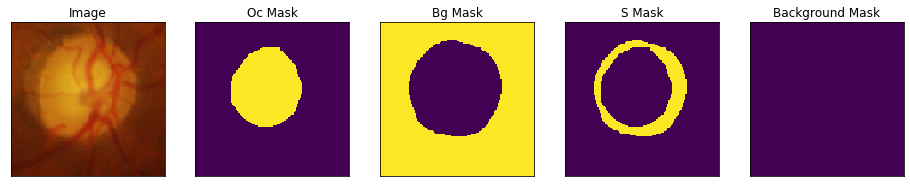

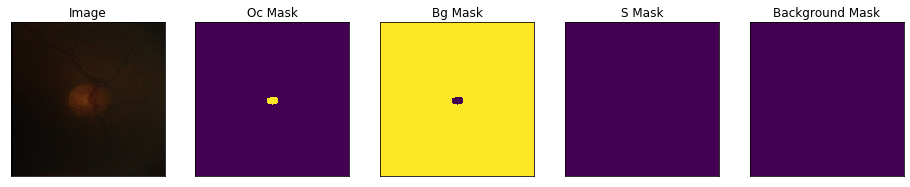

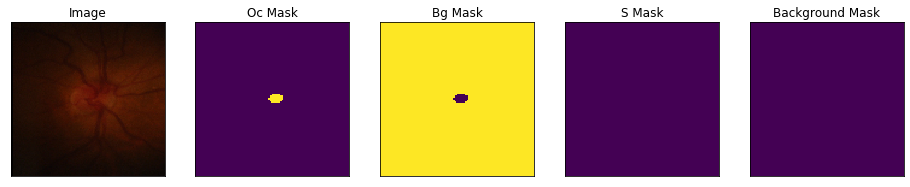

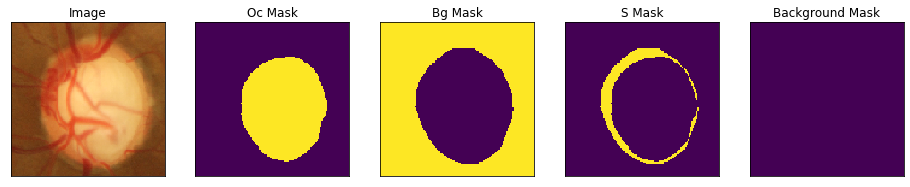

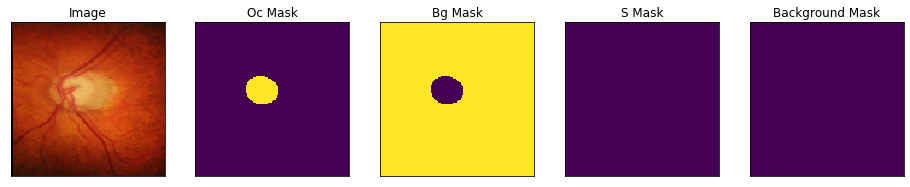

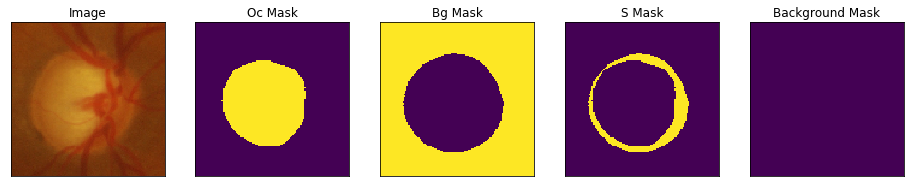

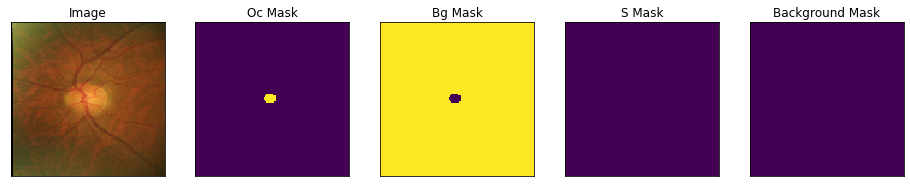

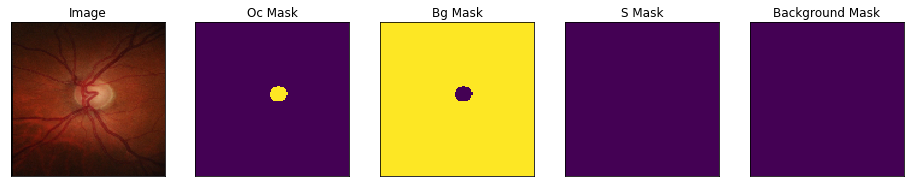

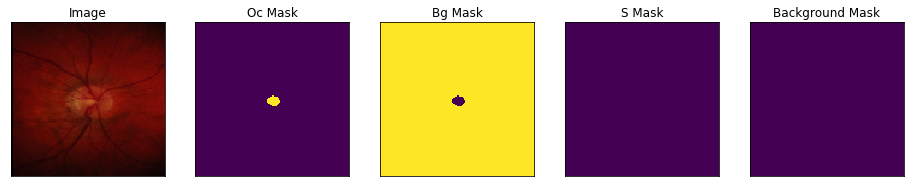

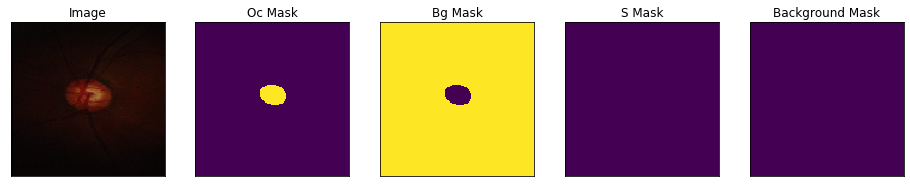

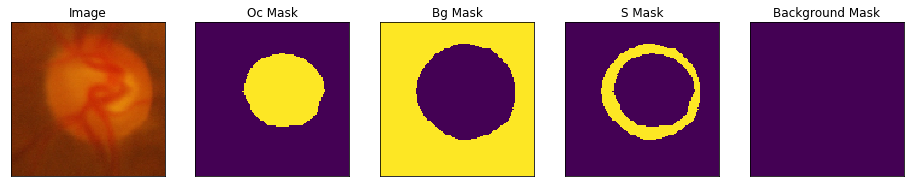

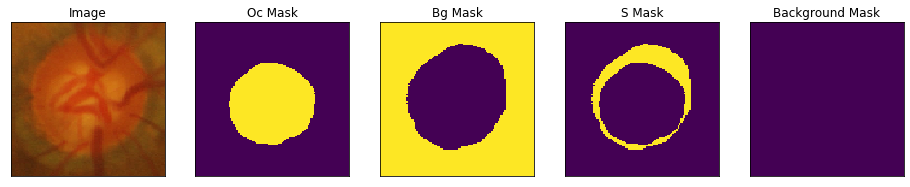

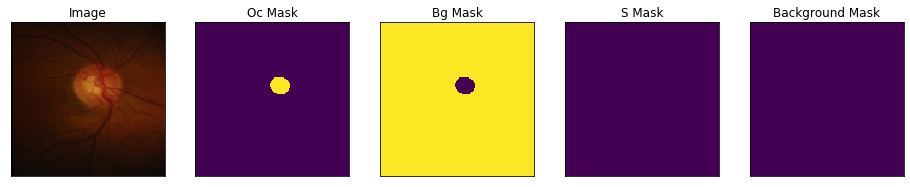

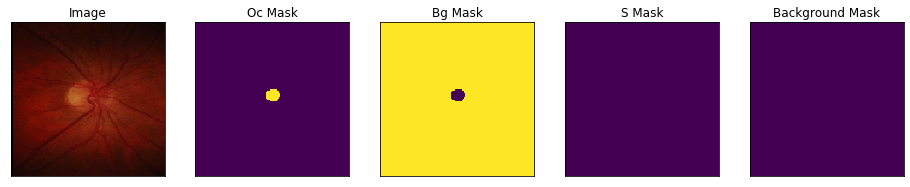

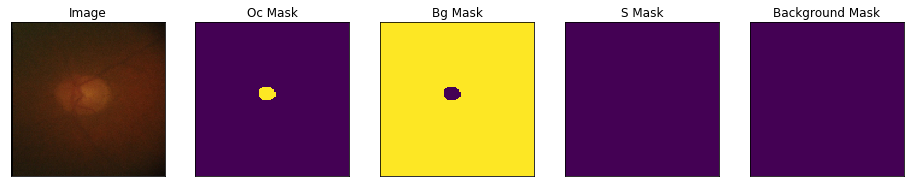

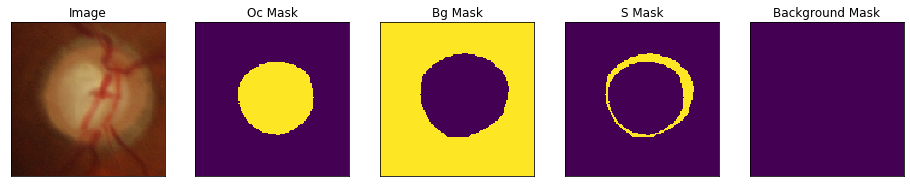

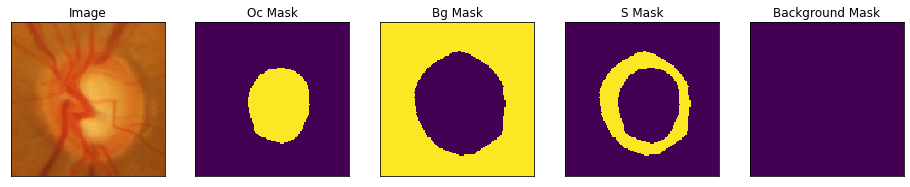

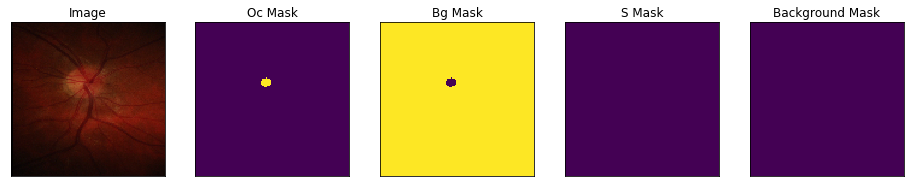

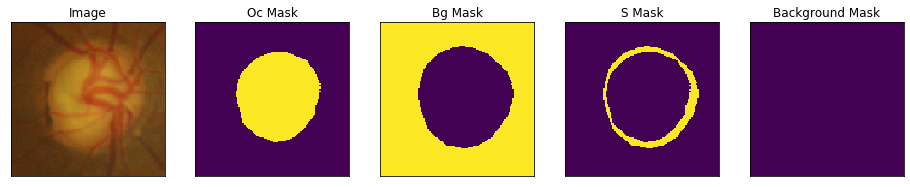

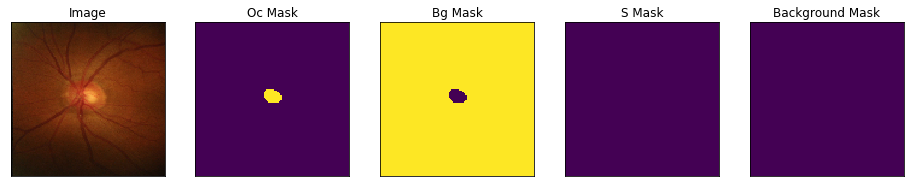

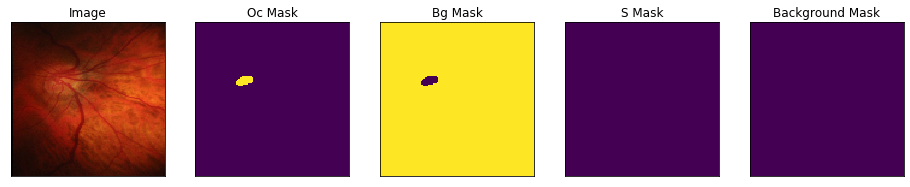

In [0]:
dataset = Dataset(x_valid_dir, y_valid_dir, classes=['oc','bg','s'])
for i in range(39):
  image, mask = dataset[i] # get some sample
  visualize(
      image=image, 
      OC_mask=mask[..., 0].squeeze(),
      bg_mask=mask[..., 1].squeeze(),
      s_mask=mask[..., 2].squeeze(),
      background_mask=mask[..., 3].squeeze(),
      )